In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [2]:
def findFiles(path):
    return glob.glob(path)

print (findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [4]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [5]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

Now we have _category lines_, a dictionary mapping each category (the languages_ to a list of lines (the names). We also kept track of _all categories_ (just a list of the languages) and _n categories_ for later reference.

In [6]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors

Now that all the names are organized, we'll turn them into tensors (using PyTorch, of course).

We will __one hot vectors__ to represent letters, with a size of ```<1 x N-letters>```

To make a word we join a bunch of our encoded letters into a 2D matrix ```line_length x 1 x n_letters```

The extra 1 dimsnesion is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [7]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').shape)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


### Creating the Network

Now we build our model. This RNN is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

In [14]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i20 = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        combined_2 = torch.cat((input, hidden), 1)
        output = self.i20(combined_2)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a precious hidden state (which we initialize a zeros at first). We'll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [15]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new tensor for every step, so we will use ```lineToTensor``` instead of ```letterToTensor``` and use slices. This could be further optimized by pre-computing batches of Tensors.

In [16]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
print('Output shape: ' + str(output.shape))

tensor([[-2.9084, -2.9004, -2.7513, -2.8818, -2.9252, -3.0584, -2.7998,
         -2.9194, -2.9569, -2.8273, -2.9158, -2.7708, -2.9389, -2.9058,
         -2.8560, -2.9050, -2.9736, -2.8783]])
Output shape: torch.Size([1, 18])


As you can see the output is a ```<a x N_categories>``` tensor, where every item is the likelihood of that category (higher is more likely).

### Training - Helper Functions

Before training, we will make a few helper functions:

The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use ```Tensor.topk``` to get the index of the greatest value:

In [17]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Arabic', 2)


We will also want a quick way to get a training example (a name and its language):

In [18]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print("Category = ", category, " / line = ", line)

Category =  Chinese  / line =  Lim
Category =  Dutch  / line =  Dalen
Category =  Russian  / line =  Tropinov
Category =  Scottish  / line =  Mcgregor
Category =  Italian  / line =  Cuoco
Category =  Spanish  / line =  Jaso
Category =  English  / line =  Forester
Category =  German  / line =  Sturm
Category =  Italian  / line =  Antonino
Category =  Japanese  / line =  Takahama


### Training the Network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

For the loss function, ```nn.NLLLoss``` is appropriate, since the last layer of the RNN is ```nn.LogSoftMax```.

In [19]:
criterion = nn.NLLLoss()

Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and keep a hidden state for the next letter
- Compare final output to target
- Back-propogate
- Return the output and loss

In [20]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add Paramaters' gradients to their vales, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the ```train``` function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples, we print only every ```print_every``` examples, and take an average of the loss.

In [25]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 1.9267 Tritten / Dutch ✗ (German)
10000 10% (0m 8s) 2.9029 Seeger / German ✗ (Dutch)
15000 15% (0m 13s) 0.0228 Ichigawa / Japanese ✓
20000 20% (0m 18s) 3.7884 Rompay / Czech ✗ (Dutch)
25000 25% (0m 23s) 0.3035 Donndubhan / Irish ✓
30000 30% (0m 28s) 1.5490 Mcneil / French ✗ (Irish)
35000 35% (0m 33s) 1.6011 Haratyan / French ✗ (Russian)
40000 40% (0m 37s) 0.0840 Allegri / Italian ✓
45000 45% (0m 41s) 0.1183 Than / Vietnamese ✓
50000 50% (0m 46s) 0.3395 Abreu / Portuguese ✓
55000 55% (0m 50s) 0.7882 Suk / Korean ✓
60000 60% (0m 55s) 1.4197 Mudra / Czech ✓
65000 65% (0m 59s) 0.5023 Sanchez / Spanish ✓
70000 70% (1m 4s) 3.1868 Ivor / German ✗ (Irish)
75000 75% (1m 8s) 2.7758 Munro / Russian ✗ (Scottish)
80000 80% (1m 13s) 2.2253 Sarkis / Greek ✗ (Arabic)
85000 85% (1m 17s) 0.4630 Szwedko / Polish ✓
90000 90% (1m 22s) 0.1349 Ferreira / Portuguese ✓
95000 95% (1m 26s) 0.6963 Vourlis / Greek ✓
100000 100% (1m 31s) 0.0854 Leontarakis / Greek ✓


### Plotting the Results

Plotting the historical loss from ```all_losses``` shows the network learning:

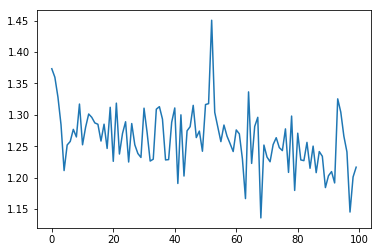

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

### Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matric a bunch of samples are run through the network with ```evaluate()```, which is the same as ```train()``` minues the backprop.

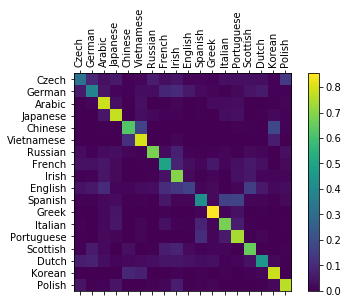

In [27]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

The bright spots off the main axis show which languages it guesses incorrectly. Chinese and Korean, for example, makes sense as their is overlap in language pattern (as well as Spanish and Italian)

### Running on User Input

In [29]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
            
predict('Dostoevsky')
predict('Rooney')
predict('Neuer')


> Dostoevsky
(-0.04) Russian
(-3.45) Czech
(-4.76) Polish

> Rooney
(-1.43) Czech
(-1.49) Dutch
(-2.16) Polish

> Neuer
(-0.77) Arabic
(-1.32) German
(-2.46) Dutch
